# Self-Driving Car Engineer Nanodegree


## Project: **Finding Lane Lines on the Road** 
***
In this project, you will use the tools you learned about in the lesson to identify lane lines on the road.  You can develop your pipeline on a series of individual images, and later apply the result to a video stream (really just a series of images). Check out the video clip "raw-lines-example.mp4" (also contained in this repository) to see what the output should look like after using the helper functions below. 

Once you have a result that looks roughly like "raw-lines-example.mp4", you'll need to get creative and try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines.  You can see an example of the result you're going for in the video "P1_example.mp4".  Ultimately, you would like to draw just one line for the left side of the lane, and one for the right.

In addition to implementing code, there is a brief writeup to complete. The writeup should be completed in a separate file, which can be either a markdown file or a pdf document. There is a [write up template](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) that can be used to guide the writing process. Completing both the code in the Ipython notebook and the writeup template will cover all of the [rubric points](https://review.udacity.com/#!/rubrics/322/view) for this project.

---
Let's have a look at our first image called 'test_images/solidWhiteRight.jpg'.  Run the 2 cells below (hit Shift-Enter or the "play" button above) to display the image.

**Note: If, at any point, you encounter frozen display windows or other confounding issues, you can always start again with a clean slate by going to the "Kernel" menu above and selecting "Restart & Clear Output".**

---

**The tools you have are color selection, region of interest selection, grayscaling, Gaussian smoothing, Canny Edge Detection and Hough Tranform line detection.  You  are also free to explore and try other techniques that were not presented in the lesson.  Your goal is piece together a pipeline to detect the line segments in the image, then average/extrapolate them and draw them onto the image for display (as below).  Once you have a working pipeline, try it out on the video stream below.**

---

<figure>
 <img src="examples/line-segments-example.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your output should look something like this (above) after detecting line segments using the helper functions below </p> 
 </figcaption>
</figure>
 <p></p> 
<figure>
 <img src="examples/laneLines_thirdPass.jpg" width="380" alt="Combined Image" />
 <figcaption>
 <p></p> 
 <p style="text-align: center;"> Your goal is to connect/average/extrapolate line segments to get output like this</p> 
 </figcaption>
</figure>

**Run the cell below to import some packages.  If you get an `import error` for a package you've already installed, try changing your kernel (select the Kernel menu above --> Change Kernel).  Still have problems?  Try relaunching Jupyter Notebook from the terminal prompt.  Also, consult the forums for more troubleshooting tips.**  

## Import Packages

In [1]:
#importing some useful packages
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
import cv2
%matplotlib inline

## Read in an Image

This image is: <class 'numpy.ndarray'> with dimensions: (540, 960, 3)


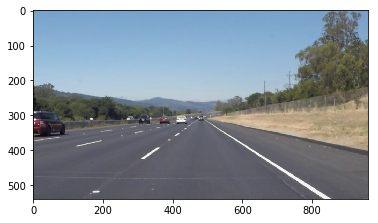

In [2]:
#reading in an image
image = mpimg.imread('test_images/solidWhiteRight.jpg')

#printing out some stats and plotting
print('This image is:', type(image), 'with dimensions:', image.shape)
plt.imshow(image)  # if you wanted to show a single color channel image called 'gray', for example, call as plt.imshow(gray, cmap='gray')

## Ideas for Lane Detection Pipeline

**Some OpenCV functions (beyond those introduced in the lesson) that might be useful for this project are:**

`cv2.inRange()` for color selection  
`cv2.fillPoly()` for regions selection  
`cv2.line()` to draw lines on an image given endpoints  
`cv2.addWeighted()` to coadd / overlay two images
`cv2.cvtColor()` to grayscale or change color
`cv2.imwrite()` to output images to file  
`cv2.bitwise_and()` to apply a mask to an image

**Check out the OpenCV documentation to learn about these and discover even more awesome functionality!**

## Helper Functions

Below are some helper functions to help get you started. They should look familiar from the lesson!

In [3]:
import math

def grayscale(img):
    """Applies the Grayscale transform
    This will return an image with only one color channel
    but NOTE: to see the returned image as grayscale
    (assuming your grayscaled image is called 'gray')
    you should call plt.imshow(gray, cmap='gray')"""
    return cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    # Or use BGR2GRAY if you read an image with cv2.imread()
    # return cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
def canny(img, low_threshold, high_threshold):
    """Applies the Canny transform"""
    return cv2.Canny(img, low_threshold, high_threshold)

def gaussian_blur(img, kernel_size):
    """Applies a Gaussian Noise kernel"""
    return cv2.GaussianBlur(img, (kernel_size, kernel_size), 0)

def region_of_interest(img, vertices):
    """
    Applies an image mask.
    
    Only keeps the region of the image defined by the polygon
    formed from `vertices`. The rest of the image is set to black.
    `vertices` should be a numpy array of integer points.
    """
    #defining a blank mask to start with
    mask = np.zeros_like(img)   
    
    #defining a 3 channel or 1 channel color to fill the mask with depending on the input image
    if len(img.shape) > 2:
        channel_count = img.shape[2]  # i.e. 3 or 4 depending on your image
        ignore_mask_color = (255,) * channel_count
    else:
        ignore_mask_color = 255
        
    #filling pixels inside the polygon defined by "vertices" with the fill color    
    cv2.fillPoly(mask, vertices, ignore_mask_color)
    
    #returning the image only where mask pixels are nonzero
    masked_image = cv2.bitwise_and(img, mask)
    return masked_image


def draw_lines(img, lines, color=[255, 0, 0], thickness=2):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
    for line in lines:
        for x1,y1,x2,y2 in line:
            cv2.line(img, (x1, y1), (x2, y2), color, thickness)

def hough_lines(img, rho, theta, threshold, min_line_len, max_line_gap):
    """
    `img` should be the output of a Canny transform.
        
    Returns an image with hough lines drawn.
    """
    lines = cv2.HoughLinesP(img, rho, theta, threshold, np.array([]), minLineLength=min_line_len, maxLineGap=max_line_gap)
    line_img = np.zeros((img.shape[0], img.shape[1], 3), dtype=np.uint8)
    draw_lines(line_img, lines)
    return line_img

# Python 3 has support for cool math symbols.

def weighted_img(img, initial_img, α=0.8, β=1., γ=0.):
    """
    `img` is the output of the hough_lines(), An image with lines drawn on it.
    Should be a blank image (all black) with lines drawn on it.
    
    `initial_img` should be the image before any processing.
    
    The result image is computed as follows:
    
    initial_img * α + img * β + γ
    NOTE: initial_img and img must be the same shape!
    """
    return cv2.addWeighted(initial_img, α, img, β, γ)

## Test Images

Build your pipeline to work on the images in the directory "test_images"  
**You should make sure your pipeline works well on these images before you try the videos.**

In [4]:
import os
os.listdir("test_images/")

['solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg']

## Build a Lane Finding Pipeline



Build the pipeline and run your solution on all test_images. Make copies into the `test_images_output` directory, and you can use the images in your writeup report.

Try tuning the various parameters, especially the low and high Canny thresholds as well as the Hough lines parameters.

In [5]:
# TODO: Build your pipeline that will draw lane lines on the test_images
# then save them to the test_images_output directory.

def pipeline_draw_lane_lines( in_img_path_source = None,
                              in_kernel_size = 5,
                              in_low_threshold = 50,
                              in_high_threshold = 150,
                              in_rho = 2,
                              in_theta = np.pi/180,
                              in_threshold = 15,
                              in_min_line_length = 40,
                              in_max_line_gap = 20 ):
    """
    Description: The pipeline is based on what was shown in the lecture with some
                 modifications.
                 
                 Some of the modifications consists of using the helper functions
                 provided in this notebook, which are wrappers to calling OpenCV API.
                 We use these because it is provided and more convinient.
    """
    #-----------
    # Local module imports
    # (Start)
    #-----------
    
    from copy import deepcopy as deepcopy
    
    #-----------
    # Local module imports
    # (End)
    #-----------
    
    #-----------
    # Variables
    # (Start)
    #-----------
    
    # Copy argument variables to local variables.
    img_path_source = deepcopy( in_img_path_source )
    kernel_size = deepcopy( in_kernel_size )
    low_threshold = deepcopy( in_low_threshold )
    high_threshold = deepcopy( in_high_threshold )
    rho = deepcopy( in_rho )
    theta = deepcopy( in_theta )
    threshold = deepcopy( in_threshold )
    min_line_length = deepcopy( in_min_line_length )
    max_line_gap = deepcopy( in_max_line_gap ) 
    
    #-----------
    # Variables
    # (End)
    #-----------
    
    # Determine the input type:
    if type(img_path_source) == np.ndarray:
        image = img_path_source
    else:
        # Read in the image
        image = mpimg.imread( img_path_source )
        
    # Change to grayscale image.
    gray = cv2.cvtColor( image,
                         cv2.COLOR_RGB2GRAY)

    # Define a kernel size and apply Gaussian smoothing
    #kernel_size = 5
    #blur_gray = cv2.GaussianBlur(gray,(kernel_size, kernel_size),0)
    blur_gray = gaussian_blur( gray,
                               kernel_size)

    # Define our parameters for Canny and apply
    #edges = cv2.Canny(blur_gray, low_threshold, high_threshold)
    edges = canny( blur_gray,
                   low_threshold,
                   high_threshold )

    # Next we'll create a masked edges image using cv2.fillPoly()
#     mask = np.zeros_like(edges)   
#     ignore_mask_color = 255   

    # This time we are defining a four sided polygon to mask
    imshape = image.shape
    #vertices = np.array([[(0,imshape[0]),(450, 290), (490, 290), (imshape[1],imshape[0])]], dtype=np.int32)
    
    # NOTE: This part is just guess and test, just like in the lecture.
    vertices = np.array([[ (100,imshape[0]),                     (imshape[1]/2-20, imshape[0]/2+45),
                           (imshape[1]/2+20, imshape[0]/2+45),   (imshape[1]-20,imshape[0])  ]],
                           dtype=np.int32 )
#     cv2.fillPoly(mask, vertices, ignore_mask_color)
#     masked_edges = cv2.bitwise_and(edges, mask)
    masked_edges = region_of_interest(edges, vertices)

    # Define the Hough transform parameters
    # Make a blank the same size as our image to draw on
    line_image = np.copy(image)*0 # creating a blank to draw lines on

    # Run Hough on edge detected image
    # Output "lines" is an array containing endpoints of detected line segments
#     lines = cv2.HoughLinesP(masked_edges, rho, theta, threshold, np.array([]),
#                                 min_line_length, max_line_gap)
    line_img = hough_lines( masked_edges,
                            rho,
                            theta,
                            threshold,
                            min_line_length,
                            max_line_gap )

#     # Iterate over the output "lines" and draw lines on a blank image
#     for line in lines:
#         for x1,y1,x2,y2 in line:
#             cv2.line(line_image,(x1,y1),(x2,y2),(255,0,0),10)

#     # Create a "color" binary image to combine with line image
#     color_edges = np.dstack((edges, edges, edges)) 

#     # Draw the lines on the edge image
#     lines_edges = cv2.addWeighted(color_edges, 0.8, line_image, 1, 0) 
#     #plt.imshow(lines_edges)

    # Output composited image
    img_output = weighted_img( line_img,
                               image )
    
    # Return the resulting image
    return img_output
    
    

In [6]:
# Get files in folder
# Get all files in folder
# https://stackoverflow.com/questions/3964681/find-all-files-in-a-directory-with-extension-txt-in-python
#import glob

# NOTE: Do not put a slash '/' at the beginning of a path.
#       Not putting it makes it a relative path.
#list_img_files = glob.glob('test_images/*.jpg')
path_images_input = "test_images/"
path_images_output = "test_images_output/"
list_img_files = os.listdir(path_images_input)

In [7]:
# How many files in folder
num_of_files = len(list_img_files)

In [8]:
num_of_files

6

In [9]:
# List files in folder
list_img_files

['solidWhiteCurve.jpg',
 'solidYellowCurve.jpg',
 'solidYellowLeft.jpg',
 'whiteCarLaneSwitch.jpg',
 'solidYellowCurve2.jpg',
 'solidWhiteRight.jpg']

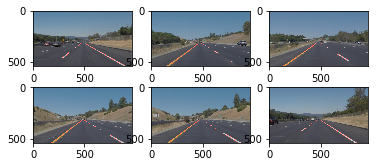

In [10]:
import os

# This is just presentatin aesthetics.
# To find the biggest square rows and columns given the number,
# take the square root and discard the decimal (i.e. just convert to int)
#
# Example:
# number of files: 90
# square root of 90 is: 9.486832980505138
# get rid of the decimal: 9
# Biggest number to give square rows and columns will be 9x9
# 9x9 gives: 81
#
# Add 1 so we know we have more grid space than images.
# This way, when we plot the image, there will be no
# out of bounds indices.
square_row_column_num = int(np.sqrt(num_of_files)) + 1

for i, img_file in enumerate(list_img_files):
    img_file = list_img_files[i]

    img_file_full_path = os.path.join( path_images_input,
                                        img_file )
    # Normalize the path
    img_file_full_path_normpath = os.path.normpath(img_file_full_path)
    
    # Execute the pipeline and capture new image produced
    #
    # NOTE: Trying different values here, i.e. another guess and test section.
    img_output = pipeline_draw_lane_lines( in_img_path_source = img_file_full_path_normpath,
                              in_kernel_size = 5,
                              in_low_threshold = 60,
                              in_high_threshold = 210,
                              in_rho = 2,
                              in_theta = np.pi/180,
                              in_threshold = 25,
                              in_min_line_length = 3,
                              in_max_line_gap = 3 )

    # Need to split the file name from the extension
    # https://stackoverflow.com/questions/541390/extracting-extension-from-filename-in-python
    filename, file_extension = os.path.splitext(img_file)
    save_path = os.path.join( path_images_output,
                              filename +"_output" +file_extension )
    save_path_normpath = os.path.normpath(save_path)
    mpimg.imsave( save_path_normpath,
                  img_output )
    
    # Format where to place the image when presented.
    # NOTE: From matplotlib.pyplot.subplot documentation.
    #       Call signature::
    #           subplot(nrows, ncols, index, **kwargs)
    #
    #       Indexes go from 1 to
    #       ``nrows * ncols``, incrementing in row-major order.
    plt.subplot( square_row_column_num,
                 square_row_column_num, 
                 i+1)
    
    # Show image
    plt.imshow( img_output )
    



## Test on Videos

You know what's cooler than drawing lanes over images? Drawing lanes over video!

We can test our solution on two provided videos:

`solidWhiteRight.mp4`

`solidYellowLeft.mp4`

**Note: if you get an import error when you run the next cell, try changing your kernel (select the Kernel menu above --> Change Kernel). Still have problems? Try relaunching Jupyter Notebook from the terminal prompt. Also, consult the forums for more troubleshooting tips.**

**If you get an error that looks like this:**
```
NeedDownloadError: Need ffmpeg exe. 
You can download it by calling: 
imageio.plugins.ffmpeg.download()
```
**Follow the instructions in the error message and check out [this forum post](https://discussions.udacity.com/t/project-error-of-test-on-videos/274082) for more troubleshooting tips across operating systems.**

In [11]:
# Import everything needed to edit/save/watch video clips
from moviepy.editor import VideoFileClip
from IPython.display import HTML

In [12]:
def process_image(image):
    # NOTE: The output you return should be a color image (3 channel) for processing video below
    # TODO: put your pipeline here,
    # you should return the final output (image where lines are drawn on lanes)

    # DEBUG
    #
    #print( "DEBUG - type(image): {}".format( type(image) ) )
    
    # NOTE: Had to update the function so that if you pass it a path to an image
    #       it will convert to a numpy.ndarray with openCV. If it is already of type
    #       numpy.ndarray, continue working with that.
    result = pipeline_draw_lane_lines( in_img_path_source = image,
                              in_kernel_size = 5,
                              in_low_threshold = 60,
                              in_high_threshold = 210,
                              in_rho = 2,
                              in_theta = np.pi/180,
                              in_threshold = 25,
                              in_min_line_length = 3,
                              in_max_line_gap = 3 )

    return result

Let's try the one with the solid white lane on the right first ...

In [13]:
white_output = 'test_videos_output/solidWhiteRight.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4").subclip(0,5)
clip1 = VideoFileClip("test_videos/solidWhiteRight.mp4")
white_clip = clip1.fl_image(process_image) #NOTE: this function expects color images!!
%time white_clip.write_videofile(white_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidWhiteRight.mp4
[MoviePy] Writing video test_videos_output/solidWhiteRight.mp4


100%|█████████▉| 221/222 [00:13<00:00, 14.65it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidWhiteRight.mp4 

CPU times: user 2.41 s, sys: 323 ms, total: 2.73 s
Wall time: 15.3 s


Play the video inline, or if you prefer find the video in your filesystem (should be in the same directory) and play it in your video player of choice.

In [14]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(white_output))

## Improve the draw_lines() function

**At this point, if you were successful with making the pipeline and tuning parameters, you probably have the Hough line segments drawn onto the road, but what about identifying the full extent of the lane and marking it clearly as in the example video (P1_example.mp4)?  Think about defining a line to run the full length of the visible lane based on the line segments you identified with the Hough Transform. As mentioned previously, try to average and/or extrapolate the line segments you've detected to map out the full extent of the lane lines. You can see an example of the result you're going for in the video "P1_example.mp4".**

**Go back and modify your draw_lines function accordingly and try re-running your pipeline. The new output should draw a single, solid line over the left lane line and a single, solid line over the right lane line. The lines should start from the bottom of the image and extend out to the top of the region of interest.**

In [15]:
# The helper function, hough_lines(), calls draw_lines(), function each time.
# We want to average the lines between frames as well, so going to keep the variables outside the draw_lines()
# function so they stay persistent.
left_lines_over_time_list = []
right_lines_over_time_list = []

def number_convolution( in_numbers,
                        in_window_size = 3 ):
    """
    Description: Use convolution to average everything out.
                 https://stackoverflow.com/questions/20036663/understanding-numpys-convolve
                 
                 Similar idea is used in convolutional neural networks (CNN)
    """
    
    # Just use the last number.
    # NOTE: This is an arbitrary decision, could have used the first number.
    if len( in_numbers ) < in_window_size:
        return [in_numbers[-1]]
    
    result = np.convolve( in_numbers,
                          np.ones((in_window_size,))/in_window_size,
                          mode = 'valid' )
    
    return result

# The draw_lines() function was provided by the Notebook earlier. Going to redefine it here to have the lines be fully
# connected and extrapolated.
# The function descriptions gives some clues on how to approach the problem.
def draw_lines(img, lines, color=[255, 0, 0], thickness=10):
    """
    NOTE: this is the function you might want to use as a starting point once you want to 
    average/extrapolate the line segments you detect to map out the full
    extent of the lane (going from the result shown in raw-lines-example.mp4
    to that shown in P1_example.mp4).  
    
    Think about things like separating line segments by their 
    slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
    line vs. the right line.  Then, you can average the position of each of 
    the lines and extrapolate to the top and bottom of the lane.
    
    This function draws `lines` with `color` and `thickness`.    
    Lines are drawn on the image inplace (mutates the image).
    If you want to make the lines semi-transparent, think about combining
    this function with the weighted_img() function below
    """
        
    left_line_segments = []
    right_line_segments = []
    
    # Have to add an extra check
    if lines is  None:
        return
    
    for line in lines:
        for x1,y1,x2,y2 in line:
            #cv2.line(img, (x1, y1), (x2, y2), color, thickness)
            
            # Think about things like separating line segments by their 
            # slope ((y2-y1)/(x2-x1)) to decide which segments are part of the left
            # line vs. the right line.
            slope = ((y2-y1)/(x2-x1))
            
            # If slope is negative, go into the left line segments list.
            if slope < 0:
                left_line_segments.append( [x1, y1 ])
                left_line_segments.append( [x2, y2 ])
                
            # Or else, it is the right line segments.
            else:
                right_line_segments.append( [x1, y1 ])
                right_line_segments.append( [x2, y2 ])
                
    # Then, you can average the position of each of 
    # the lines and extrapolate to the top and bottom of the lane.
    
    # We can use least squares polynomial fit with degree 1 using numpy.polyfit
    # The result will give the coeffients that will result with the minimal 
    # least squares error.
    #
    # NOTE: In the 1 degree case, it is a linear equation being solved.
    #       y = mx + b
    #       The coefficients will be for (m, b) or in other words
    #       the slope and the intercept.
    if len(left_line_segments) > 0 :
        left_x_component_list = [x[0] for x in left_line_segments]
        left_y_component_list = [y[1] for y in left_line_segments]
        left_coefficients = np.polyfit( left_x_component_list, 
                                        left_y_component_list,
                                        1 ).tolist()
        
        # DEBUG
        #
        #print("DEBUG - left_coefficients: {}".format( left_coefficients ))
        
        #       The coefficients will be for (m, b) or in other words
        #       the slope and the intercept.
        left_slope = left_coefficients[0]
        left_intercept = left_coefficients[1]
        
        # Add to the list of coefficients over time
        # The very first one must be added.
        # However, any subsequent ones, we will look at the slope and make sure it is
        # within a good range. If it deviates to much, we will ignore it.
        if len( left_lines_over_time_list ) == 0:
            left_lines_over_time_list.append(left_coefficients)
        elif abs(left_slope) > 0.5 and abs(left_slope) < 1.0:
            left_lines_over_time_list.append(left_coefficients)
        
    # 
    if len(right_line_segments) > 0:
        right_x_component_list = [x[0] for x in right_line_segments]
        right_y_component_list = [y[1] for y in right_line_segments]
        right_coefficients = np.polyfit( right_x_component_list, 
                                         right_y_component_list,
                                         1 ).tolist()
    
        # DEBUG
        #
        #print("DEBUG - right_coefficients: {}".format( right_coefficients ))

        #       The coefficients will be for (m, b) or in other words
        #       the slope and the intercept.
        right_slope = right_coefficients[0]
        right_intercept = right_coefficients[1]
        
        # Add to the list of coefficients over time
        # The very first one must be added.
        # However, any subsequent ones, we will look at the slope and make sure it is
        # within a good range. If it deviates to much, we will ignore it.
        if len( right_lines_over_time_list ) == 0:
            right_lines_over_time_list.append(right_coefficients)
        elif abs(right_slope) > 0.5 and abs(right_slope) < 1.0:
            right_lines_over_time_list.append(right_coefficients)

    # Checking all the slopes we have over time (i.e. multiple frames) we have so far.
    left_slopes = [x[0] for x in left_lines_over_time_list]
    left_intercepts = [x[1] for x in left_lines_over_time_list]
    #
    left_slope_over_time_averaged_list = number_convolution(left_slopes)
    left_intercepts_over_time_averaged_list = number_convolution(left_intercepts)
    #
    # Just take the last one from the list returned (it actually a numpy.ndarray,
    # list is just easier to visualize)
    #
    left_slope_over_time_last = left_slope_over_time_averaged_list[-1]
    left_intercept_over_time_last = left_intercepts_over_time_averaged_list[-1]
    #
    # Extrapolation
    # NOTE: in openCV .shape[0] is the y-axis, and .shape[1] is the x-axis
    left_y1 = img.shape[0]
    #
    # linear equation:
    # y = mx + b
    # Rearranged:
    # y - b = mx
    # (y - b)/m = x
    # x = (y - b)/m
    left_x1 = int( (left_y1 - left_intercept_over_time_last) / left_slope_over_time_last )
    #
    # For the second point, make it a percentage of y1.
    # NOTE: It must be integers because it is an image.
    left_y2 = int( 0.6*left_y1 )
    left_x2 = int( (left_y2 - left_intercept_over_time_last) / left_slope_over_time_last )
    
    
    
    #--------------
    
    
    
    # Checking all the slopes we have over time (i.e. multiple frames) we have so far.
    right_slopes = [x[0] for x in right_lines_over_time_list]
    right_intercepts = [x[1] for x in right_lines_over_time_list]
    #
    right_slope_over_time_averaged_list = number_convolution(right_slopes)
    right_intercepts_over_time_averaged_list = number_convolution(right_intercepts)
    #
    # Just take the last one from the list returned (it actually a numpy.ndarray,
    # list is just easier to visualize)
    #
    right_slope_over_time_last = right_slope_over_time_averaged_list[-1]
    right_intercept_over_time_last = right_intercepts_over_time_averaged_list[-1]
    #
    # Extrapolation
    # NOTE: in openCV .shape[0] is the y-axis, and .shape[1] is the x-axis
    right_y1 = img.shape[0]
    #
    # linear equation:
    # y = mx + b
    # Rearranged:
    # y - b = mx
    # (y - b)/m = x
    # x = (y - b)/m
    right_x1 = int( (right_y1 - right_intercept_over_time_last) / right_slope_over_time_last )
    #
    # For the second point, make it a percentage of y1.
    # NOTE: It must be integers because it is an image.
    right_y2 = int( 0.6*right_y1 )
    right_x2 = int( (right_y2 - right_intercept_over_time_last) / right_slope_over_time_last )
    
    # Now we can mutate the image an overlay it.
    cv2.line(img, (left_x1, left_y1), (left_x2, left_y2), color, thickness)
    cv2.line(img, (right_x1, right_y1), (right_x2, right_y2), color, thickness)
        
        

Now for the one with the solid yellow lane on the left. This one's more tricky!

In [16]:
yellow_output = 'test_videos_output/solidYellowLeft.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4').subclip(0,5)
clip2 = VideoFileClip('test_videos/solidYellowLeft.mp4')
yellow_clip = clip2.fl_image(process_image)
%time yellow_clip.write_videofile(yellow_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/solidYellowLeft.mp4
[MoviePy] Writing video test_videos_output/solidYellowLeft.mp4


100%|█████████▉| 681/682 [00:46<00:00, 14.05it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/solidYellowLeft.mp4 

CPU times: user 8.32 s, sys: 976 ms, total: 9.29 s
Wall time: 48.1 s


In [17]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(yellow_output))

## Writeup and Submission

If you're satisfied with your video outputs, it's time to make the report writeup in a pdf or markdown file. Once you have this Ipython notebook ready along with the writeup, it's time to submit for review! Here is a [link](https://github.com/udacity/CarND-LaneLines-P1/blob/master/writeup_template.md) to the writeup template file.


## Optional Challenge

Try your lane finding pipeline on the video below.  Does it still work?  Can you figure out a way to make it more robust?  If you're up for the challenge, modify your pipeline so it works with this video and submit it along with the rest of your project!

In [18]:
challenge_output = 'test_videos_output/challenge.mp4'
## To speed up the testing process you may want to try your pipeline on a shorter subclip of the video
## To do so add .subclip(start_second,end_second) to the end of the line below
## Where start_second and end_second are integer values representing the start and end of the subclip
## You may also uncomment the following line for a subclip of the first 5 seconds
##clip3 = VideoFileClip('test_videos/challenge.mp4').subclip(0,5)
clip3 = VideoFileClip('test_videos/challenge.mp4')
challenge_clip = clip3.fl_image(process_image)
%time challenge_clip.write_videofile(challenge_output, audio=False)

[MoviePy] >>>> Building video test_videos_output/challenge.mp4
[MoviePy] Writing video test_videos_output/challenge.mp4


100%|██████████| 251/251 [00:32<00:00,  7.48it/s]


[MoviePy] Done.
[MoviePy] >>>> Video ready: test_videos_output/challenge.mp4 

CPU times: user 5.77 s, sys: 516 ms, total: 6.29 s
Wall time: 36.4 s


In [19]:
HTML("""
<video width="960" height="540" controls>
  <source src="{0}">
</video>
""".format(challenge_output))